In [1]:
source("./polyjit.R")
source("./shiny-data.R")

Package 'sm', version 2.2-5.4: type help(sm) for summary information


In [11]:
library(RPostgres)

con <- dbConnect(RPostgres::Postgres(),
                 dbname="pprof",
                 user="pprof",
                 host="localhost",
                 port=32769,
                 password="pprof")

In [12]:
get_experiments(connection = con)

,experiment_group,experiment_name,completed
1,c1b47f0b-e87f-4cc2-9864-4002700361a6,polyjit,2015-07-20 05:19:35.275039


In [13]:
q <- paste("REFRESH MATERIALIZED VIEW run_likwid WITH DATA;")
qr <- dbSendQuery(con, q)
res <- dbFetch(qr)
dbClearResult(qr)

[1] TRUE

In [14]:
qr <- dbSendQuery(con, "SELECT COUNT(DISTINCT(project_name)), experiment_name FROM run_log GROUP BY experiment_name, experiment_group;")
res <- dbFetch(qr)
head(res)


,count,experiment_name
1,30,polyjit


In [119]:
#runtime <- "SELECT project_name as Project, region, MAX(value) as runtime
# FROM run_likwid  WHERE metric = 'RDTSC Runtime [s]' AND (core != 'Min' AND core != 'Max' AND core != 'Avg')
# AND region not like 'po%yjit.%' AND project_name = '2mm'
# GROUP BY Project, run_group, region, metric ORDER BY project;"
runtime <- "
 SELECT project, num_cores, SUM(runtime) as runtime FROM
    (
        SELECT project_name as Project, region, COUNT(region) as num_cores, MAX(value) as runtime
        FROM run_likwid
        WHERE metric = 'RDTSC Runtime [s]'
        AND (core != 'Min' AND core != 'Max' AND core != 'Avg')
        AND region not like 'po%%yjit.%%'
        GROUP BY Project, run_group, region, metric ORDER BY num_cores, project, run_group
    ) as run_likwid_f
 GROUP BY project, num_cores;"

qr.runtime <- dbSendQuery(con, runtime)
res.runtime <- dbFetch(qr.runtime)
dbClearResult(qr.runtime)
res.runtime <- melt(res.runtime, id.vars = c("project", "num_cores"))

[1] TRUE

In [122]:
overhead <- "
 SELECT project, num_cores, SUM(overhead) as overhead FROM
    (
        SELECT project_name as Project, region, COUNT(region) as num_cores, MAX(value) as overhead
        FROM run_likwid
        WHERE metric = 'RDTSC Runtime [s]'
        AND (core != 'Min' AND core != 'Max' AND core != 'Avg')
        AND region like 'po%%yjit%%' AND not region = 'polyjit.main'
        GROUP BY Project, run_group, region, metric ORDER BY num_cores, project, run_group
    ) as run_likwid_f
 GROUP BY project, num_cores;"

qr.overhead <- dbSendQuery(con, overhead)
res.overhead <- dbFetch(qr.overhead)
dbClearResult(qr.overhead)
res.overhead <- melt(res.overhead, id.vars = c("project", "num_cores"))

[1] TRUE

In [131]:
total <- "
 SELECT project, num_cores, SUM(total) as total FROM
    (
         SELECT project_name as Project, region, COUNT(region) as num_cores, MAX(value) as total
         FROM run_likwid
         WHERE metric = 'RDTSC Runtime [s]'
         AND (core != 'Min' AND core != 'Max' AND core != 'Avg')
         AND region = 'polyjit.main'
         GROUP BY Project, run_group, region, metric ORDER BY num_cores, project, run_group
    ) as run_likwid_f
 GROUP BY project, num_cores;"

qr.total <- dbSendQuery(con, total)
res.total <- dbFetch(qr.total)
dbClearResult(qr.total)
res.total <- melt(res.total, id.vars = c("project", "num_cores"))

[1] TRUE

In [132]:
res <- rbind(res.runtime, res.overhead)
res <- rbind(res, res.total)

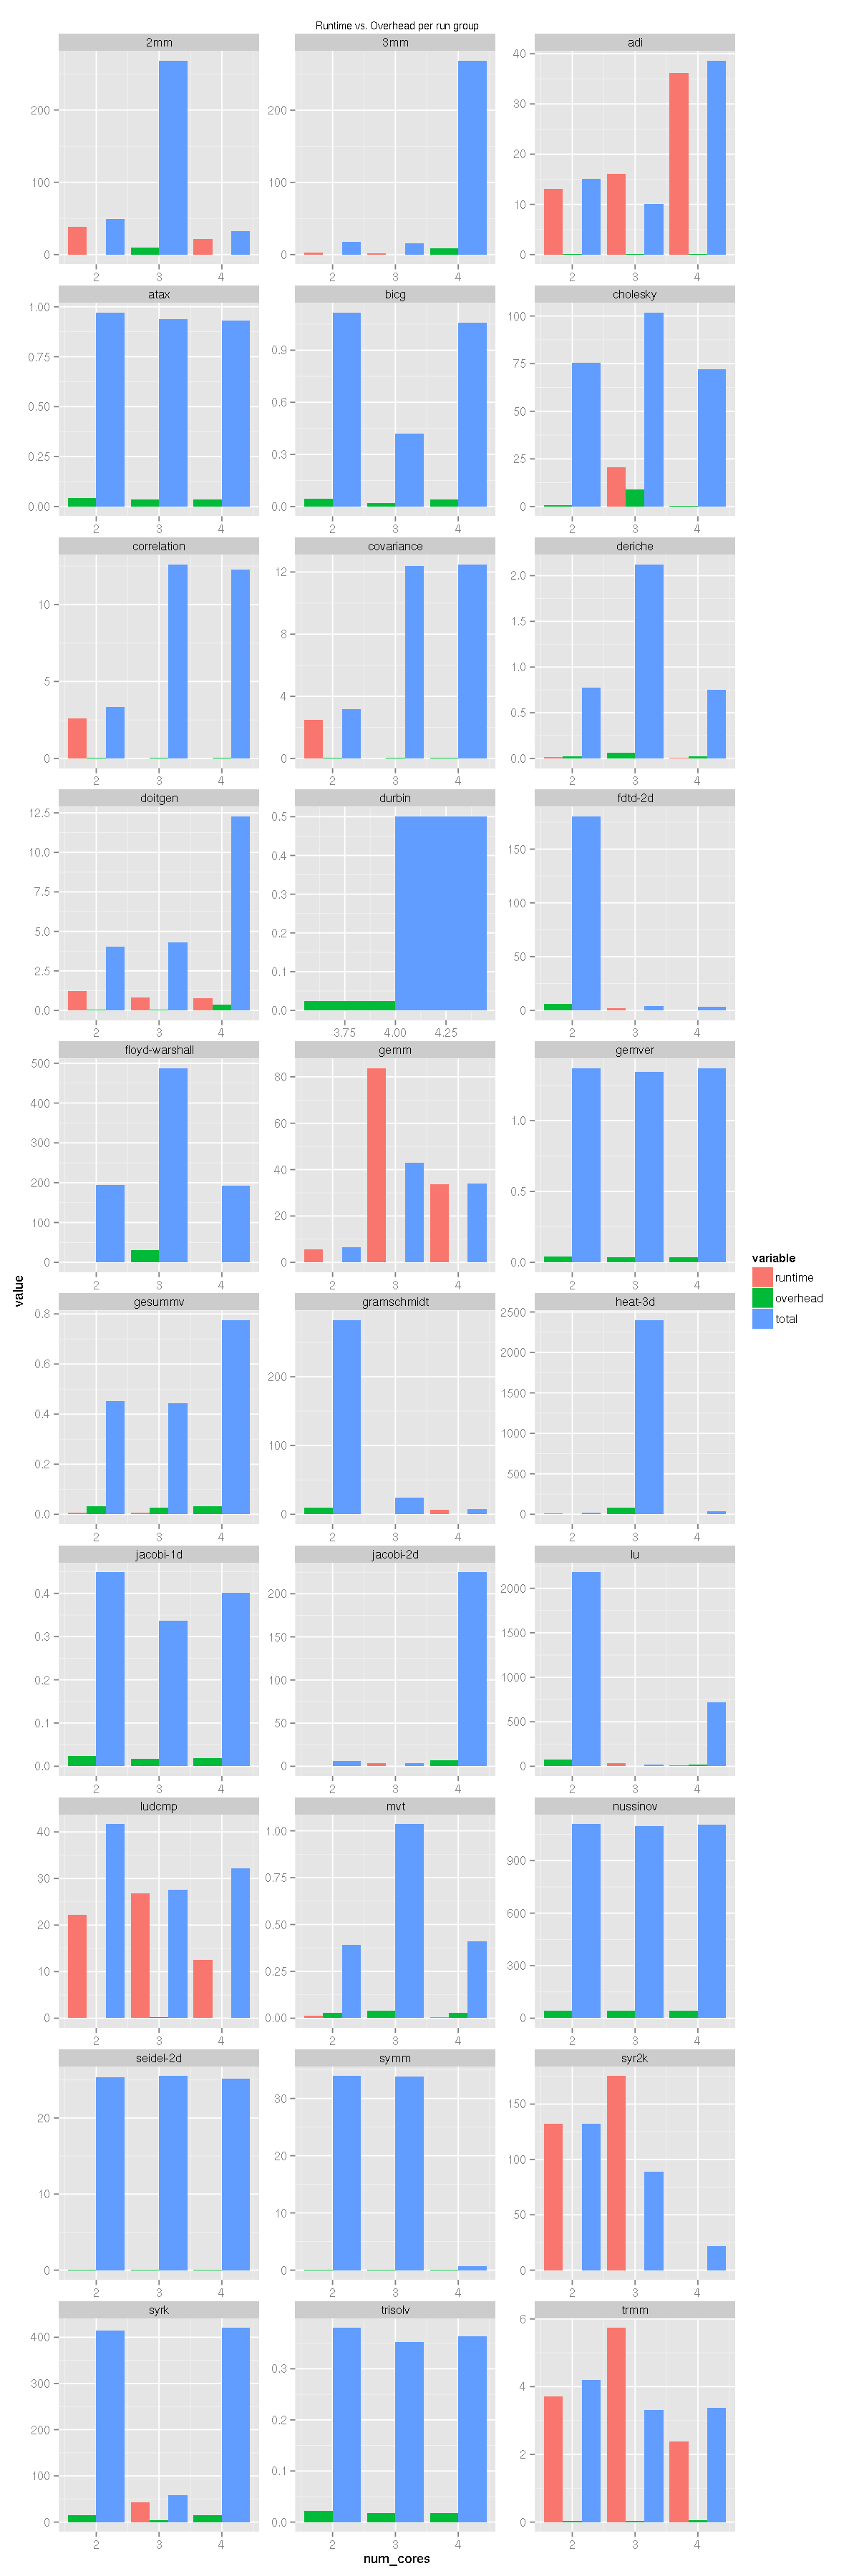

In [133]:
options(repr.plot.family = 'mono', repr.plot.width = 10, repr.plot.height = 30, warn = -1)
p <- ggplot(data=res, aes(x=num_cores, y=value, fill=variable))
p <- p + geom_bar(position="dodge", stat="identity")
#p <- p + geom_text(aes(x=num_cores,y=value,label=region),vjust=0) 
p <- p + facet_wrap( ~ project, scales = "free", ncol = 3)
p <- p + ggtitle(label = "Runtime vs. Overhead per run group")
p <- p + theme(#axis.text.x = element_blank(),
               #axis.text.x = element_text(angle = 45, hjust = 1),
               plot.title = element_text(size = 8))
p